In [74]:
import os
from dotenv import load_dotenv
from typing import Literal
from pprint import pprint
from langchain import hub
from typing import Literal,List
from typing_extensions import TypedDict
from langgraph.graph import END,START,StateGraph
from langchain.schema import Document
from langchain_core.output_parsers import StrOutputParser
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings,ChatOpenAI
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import Field,BaseModel
from langchain_community.tools.tavily_search import TavilySearchResults



load_dotenv()
langchain_api = os.getenv('LANGCHAIN_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

### Indexing

In [11]:
docs = [WebBaseLoader(url).load() for url in urls]
doc_list = [item for sublist in docs for item in sublist ]
doc_list

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size = 250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(doc_list)

vectorspace = Chroma.from_documents(
    documents=doc_splits,
    collection_name='rag_chroma',
    embedding=OpenAIEmbeddings()
)

retriever = vectorspace.as_retriever()

### Retrieval Grader


In [19]:
class GradeDocuments(BaseModel):
    binary_score : Literal["yes","no"] = Field(
        description="Documents are relevant to the question, 'yes', or 'no'"
    )

llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)
structured_llm_grader = llm.with_structured_output(GradeDocuments)

system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system" , system),
        ("user", "Retrieved document: \n\n {document} \n\n User question: {question}")
    ]
)

retrieved_grader_chain = (grade_prompt|structured_llm_grader)
question = "agent memory"
relevant_docs = retriever.get_relevant_documents(question)
retrieved_grader_chain.invoke({'question':question,"document":relevant_docs})


/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/langchain_openai/chat_models/base.py:1900: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
/var/folders/v9/yz64p8z5579c6d6yx28446qh0000gn/T/ipykernel_36298/402316597.py:21: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  relevant_docs = retriever.get_relevant_documents(question)


GradeDocuments(binary_score='yes')

### Generate

In [26]:

prompt = hub.pull("rlm/rag-prompt")

llm = ChatOpenAI(model='gpt-3.5-turbo', temperature=0)
rag_chain = (
    prompt|llm|StrOutputParser()
)

generation = rag_chain.invoke({'question':question,"context":relevant_docs})
generation


"The agent's memory includes short-term memory for in-context learning and long-term memory for retaining and recalling information over extended periods. Long-term memory is often supported by an external vector store for fast retrieval. Memory is a crucial component in enabling agents to behave based on past experiences and interact with other agents."

### Question Re-writer

In [90]:
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
re_write_prompt = ChatPromptTemplate.from_messages(
    [("system",system),
    ("user", "Here is the initial question: \n\n {question} \n Formulate an improved question."),
])

question_rewriter = re_write_prompt|llm|StrOutputParser()
question_rewriter.invoke({"question": question})


'What is the role of memory in artificial intelligence agents?'

### Web Search Tool

In [41]:
web_search_tool = TavilySearchResults(k=3)


### Define Graph State

In [100]:
class GraphState(TypedDict):

    question: str
    generation: str
    web_search:str
    documents: List[str]



def retrieve(state):

    print("---RETRIEVE---")
    question = state["question"]
    documents =retriever.get_relevant_documents(question)

    return {"documents":documents, "question":question}



def generate(state):

    print("---GENERATE---")
    question = state['question']
    documents = state['documents']

    generation = rag_chain.invoke({'question':question,"context":documents})
    return {"documents": documents, "question": question, "generation": generation}



def grade_documents(state):

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state['question']
    documents = state['documents']

    filtered_docs = []
    web_search = "No"

    for d in documents:
        score = retrieved_grader_chain.invoke({
            'question':question,"document":documents})
        if score == 'yes':
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search='Yes'
            continue
    return {"documents": documents, "question": question, "web_search": web_search}

            

def transform_query(state):

    print("---TRANSFORM QUERY---")
    question = state['question']
    documents = state['documents']

    better_question = question_rewriter.invoke({"question":question})
    return {"documents": documents, "question": better_question}

    
def web_search(state):

    print("---WEB SEARCH---")
    question = state['question']
    documents = state['documents']

    docs = web_search_tool.invoke({"query":question})
    web_content = '\n'.join([ i['content']  for i in docs])
    web_results = Document(page_content=web_content)
    documents.append(web_results)

    return {"documents":documents, "question":question}


def decide_to_generate(state):

    print("---ASSESS GRADED DOCUMENTS---")
    # state["question"]
    web_search = state["web_search"]
    # state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"



### Building Graph

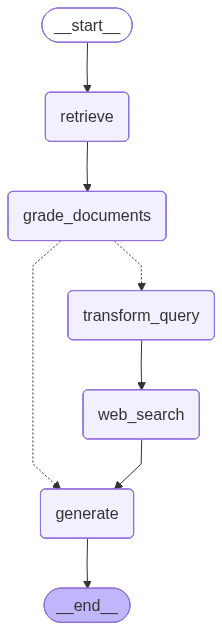

In [101]:
workflow = StateGraph(GraphState)

workflow.add_node("retrieve",retrieve)
workflow.add_node('grade_documents',grade_documents)
workflow.add_node("generate",generate)
workflow.add_node('transform_query',transform_query)
workflow.add_node(web_search,"web_search")

workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve","grade_documents")
workflow.add_conditional_edges(
    'grade_documents',
    decide_to_generate,
    {"generate":"generate",
     "transform_query":'transform_query'}
)
workflow.add_edge("transform_query","web_search")
workflow.add_edge("web_search","generate")
workflow.add_edge("generate",END)

app = workflow.compile()
app

### RUN the Graph

In [106]:
input = {"question": "What are the types of agent memory?"}
for i in app.stream(input):
    for k,v in i.items():
        pprint(f"Node '{k}':")

pprint(v["generation"])

---RETRIEVE---
"Node 'retrieve':"
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade_documents':"
---TRANSFORM QUERY---
"Node 'transform_query':"
---WEB SEARCH---
"Node 'web_search':"
---GENERATE---
"Node 'generate':"
('The different categories of memory in agents are short-term memory and '
 'long-term memory. Short-term memory is used for immediate context within a '
 'single interaction, while long-term memory persists knowledge across '
 'sessions and tasks. These memory types play different cognitive functions in '
 'building intelligent agents.')
